# Seq 2 Seq con Atención para traducción automática

[[Paper](https://arxiv.org/pdf/1409.0473.pdf)]

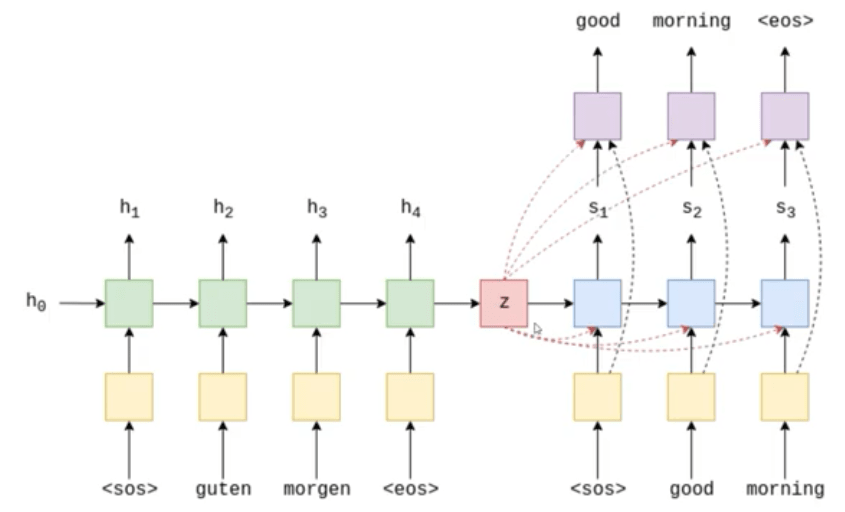

In [1]:
!pip install torchtext
!python -m spacy download de
!python -m spacy download en

     |████████████████████████████████| 14.9MB 6.2MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp37-none-any.whl size=14907055 sha256=471c68e39d58869d0788ce776eba0b9a271bf72e70bce3247acd3d65669f1c02
  Stored in directory: /tmp/pip-ephem-wheel-cache-3zi5jlz9/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import spacy
from torchtext.data.metrics import bleu_score
import sys
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

In [4]:
def translate_sentence(model, sentence, german, english, device, max_length=50):
    # Load german tokenizer
    spacy_ger = spacy.load("de")

    # Create tokens using spacy and everything in lower case (which is what our vocab is)
    if type(sentence) == str:
        tokens = [token.text.lower() for token in spacy_ger(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # Add <SOS> and <EOS> in beginning and end respectively
    tokens.insert(0, german.init_token)
    tokens.append(german.eos_token)

    # Go through each german token and convert to an index
    text_to_indices = [german.vocab.stoi[token] for token in tokens]

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        outputs_encoder, hiddens, cells = model.encoder(sentence_tensor)

    outputs = [english.vocab.stoi["<sos>"]]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hiddens, cells = model.decoder(
                previous_word, outputs_encoder, hiddens, cells
            )
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # Model predicts it's the end of the sentence
        if output.argmax(1).item() == english.vocab.stoi["<eos>"]:
            break

    translated_sentence = [english.vocab.itos[idx] for idx in outputs]

    # remove start token
    return translated_sentence[1:]


def bleu(data, model, german, english, device):
    targets = []
    outputs = []

    for example in data:
        src = vars(example)["src"]
        trg = vars(example)["trg"]

        prediction = translate_sentence(model, src, german, english, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append([trg])
        outputs.append(prediction)

    return bleu_score(outputs, targets)


def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [5]:
"""
To install spacy languages do:
python -m spacy download en
python -m spacy download de
"""
spacy_ger = spacy.load("de")
spacy_eng = spacy.load("en")


def tokenize_ger(text):
    return [tok.text for tok in spacy_ger.tokenizer(text)]


def tokenize_eng(text):
    return [tok.text for tok in spacy_eng.tokenizer(text)]


german = Field(tokenize=tokenize_ger, lower=True, init_token="<sos>", eos_token="<eos>")

english = Field(
    tokenize=tokenize_eng, lower=True, init_token="<sos>", eos_token="<eos>"
)

train_data, valid_data, test_data = Multi30k.splits(
    exts=(".de", ".en"), fields=(german, english)
)

german.build_vocab(train_data, max_size=10000, min_freq=2)
english.build_vocab(train_data, max_size=10000, min_freq=2)

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 1.14MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 170kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 169kB/s]


In [6]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell


class Decoder(nn.Module):
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(hidden_size * 2 + embedding_size, hidden_size, num_layers)

        self.energy = nn.Linear(hidden_size * 3, 1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, x, encoder_states, hidden, cell):
        x = x.unsqueeze(0)
        # x: (1, N) where N is the batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        energy = self.relu(self.energy(torch.cat((h_reshaped, encoder_states), dim=2)))
        # energy: (seq_length, N, 1)

        attention = self.softmax(energy)
        # attention: (seq_length, N, 1)

        # attention: (seq_length, N, 1), snk
        # encoder_states: (seq_length, N, hidden_size*2), snl
        # we want context_vector: (1, N, hidden_size*2), i.e knl
        context_vector = torch.einsum("snk,snl->knl", attention, encoder_states)

        rnn_input = torch.cat((context_vector, embedding), dim=2)
        # rnn_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = len(english.vocab)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden, cell = self.encoder(source)

        # First input will be <SOS> token
        x = target[0]

        for t in range(1, target_len):
            # At every time step use encoder_states and update hidden, cell
            output, hidden, cell = self.decoder(x, encoder_states, hidden, cell)

            # Store prediction for current time step
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[t] if random.random() < teacher_force_ratio else best_guess

        return outputs

In [7]:
### We're ready to define everything we need for training our Seq2Seq model ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True

# Training hyperparameters
num_epochs = 100
learning_rate = 3e-4
batch_size = 32

# Model hyperparameters
input_size_encoder = len(german.vocab)
input_size_decoder = len(english.vocab)
output_size = len(english.vocab)
encoder_embedding_size = 300
decoder_embedding_size = 300
hidden_size = 1024
num_layers = 1
enc_dropout = 0.0
dec_dropout = 0.0

# Tensorboard to get nice loss plot
writer = SummaryWriter(f"runs/loss_plot")
step = 0

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device,
)

encoder_net = Encoder(
    input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout
).to(device)

decoder_net = Decoder(
    input_size_decoder,
    decoder_embedding_size,
    hidden_size,
    output_size,
    num_layers,
    dec_dropout,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = english.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

'''
# un barco con varios hombres es arrastrado a tierra por un gran equipo de caballos
# a boat with several men on it is pulled ashore by a large team of horses.
sentence = "ein boot mit mehreren männern darauf wird von einem großen pferdegespann ans ufer gezogen."
'''

sentence = (
    "ein boot mit mehreren männern darauf wird von einem großen"
    "pferdegespann ans ufer gezogen."
)

In [8]:
for epoch in range(num_epochs):
    print(f"[Epoch {epoch} / {num_epochs}]")

    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

    model.eval()

    translated_sentence = translate_sentence(
        model, sentence, german, english, device, max_length=50
    )

    print(f"Translated example sentence: \n {translated_sentence}")

    model.train()

    for batch_idx, batch in enumerate(train_iterator):
        # Get input and targets and get to cuda
        inp_data = batch.src.to(device)
        target = batch.trg.to(device)

        # Forward prop
        output = model(inp_data, target)

        # Output is of shape (trg_len, batch_size, output_dim) but Cross Entropy Loss
        # doesn't take input in that form. For example if we have MNIST we want to have
        # output to be: (N, 10) and targets just (N). Here we can view it in a similar
        # way that we have output_words * batch_size that we want to send in into
        # our cost function, so we need to do some reshapin. While we're at it
        # Let's also remove the start token while we're at it
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)

        # Back prop
        loss.backward()

        # Clip to avoid exploding gradient issues, makes sure grads are
        # within a healthy range
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Gradient descent step
        optimizer.step()

        # Plot to tensorboard
        writer.add_scalar("Training loss", loss, global_step=step)
        step += 1

# running on entire test data takes a while
score = bleu(test_data[1:100], model, german, english, device)
print(f"Bleu score {score * 100:.2f}")

[Epoch 0 / 100]
=> Saving checkpoint
Translated example sentence: 
 ['preparation', 'bartender', 'split', 'enthusiasm', 'enthusiasm', 'country', 'cartwheel', 'patient', 'patient', 'patient', 'caged', 'ahead', 'blocking', 'blocked', 'cable', 'pedestrian', 'only', 'cola', 'cola', 'barricade', 'batman', 'instructions', 'brazil', 'little', 'sexy', 'maintenance', 'intersection', 'smooth', 'array', 'brook', 'heartbeat', 'reception', 'roots', 'flood', 'nibbles', 'wading', 'juggler', 'specialized', 'scrabble', 'buckets', 'decorations', 'iced', 'merry', 'cutting', "'", 'spending', 'seashore', 'early', 'hook', 'flooded']


KeyboardInterrupt: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/loss_plot